In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
import utilities


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/tmp/ipykernel_14716/2928747477.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# ticker = "MSFT"
# df = utilities.load_stock(ticker)
ticker = 'SPY'
df = utilities.load_index(ticker)


In [3]:
df = utilities.RSI(df, 14)
df = utilities.RSI(df, 28)
df = utilities.RSI(df, 56)
df = utilities.RSI(df, 100)
df = utilities.RSI(df, 200)

df = utilities.MACD(df)

df = utilities.EMA(df, 10)
df = utilities.EMA(df, 50)
df = utilities.EMA(df, 200)

df = utilities.market_hours_only(df)

df.head()

,timestamp,open,high,low,close,volume,ticker,date,time,rsi14,rsi28,rsi56,rsi100,rsi200,macd,signal,histogram,ema10,ema50,ema200
56,2005-01-03 09:30:00,121.56,121.57,121.49,121.50,349600,SPY,2005-01-03,09:30:00,40.6250,41.6667,47.3684,NaN,NaN,-0.0158,-0.0156,-0.0002,121.5111,121.5393,NaN
57,2005-01-03 09:31:00,121.50,121.56,121.49,121.56,205300,SPY,2005-01-03,09:31:00,48.6486,49.0566,51.2195,NaN,NaN,-0.0110,-0.0147,0.0037,121.5200,121.5402,NaN
58,2005-01-03 09:32:00,121.56,121.58,121.52,121.53,159600,SPY,2005-01-03,09:32:00,45.0000,48.1481,48.1928,NaN,NaN,-0.0094,-0.0136,0.0042,121.5218,121.5397,NaN
59,2005-01-03 09:33:00,121.53,121.60,121.52,121.57,165500,SPY,2005-01-03,09:33:00,50.0000,51.7241,51.1628,NaN,NaN,-0.0049,-0.0119,0.0069,121.5306,121.5410,NaN
60,2005-01-03 09:34:00,121.59,121.66,121.57,121.63,371700,SPY,2005-01-03,09:34:00,59.5745,57.1429,54.3478,NaN,NaN,0.0034,-0.0088,0.0122,121.5486,121.5449,NaN


In [4]:
# # Price normalizing

# days = utilities.list_of_day_dfs(df)
# days = [group.copy() for _, group in df.groupby(df['timestamp'].dt.date)]

# # for each day: sort the prices, then normalize them to 0-1 where 0 is the lowest price and 1 is the highest price for that day
# for day in days:
#     for col in ['high', 'low', 'volume', 'macd', 'signal', 'histogram', 'rsi14', 'rsi28', 'rsi56', 'ema10', 'ema50', 'ema200']:
#         day[col] = (day[col] - day[col].min()) / (day[col].max() - day[col].min())

# # recombine the days
# df = pd.concat(days)

In [5]:
# Price normalizing needs to be the only metric that's forward looking

# Create a new column called 'enter' that represents whether or not the price will he higher or lower in $(some many) minutes
# 1 if the price will be higher, 0 if the price will be lower
df['enter'] = (df['close'].shift(-(60*7*5*4)) > df['close']).astype(int)
df = df.drop(columns=['open', 'close', 'timestamp', 'ticker', 'date', 'time'])

In [6]:
df.describe()

,high,low,volume,rsi14,rsi28,rsi56,rsi100,rsi200,macd,signal,histogram,ema10,ema50,ema200,enter
56,121.57,121.49,349600,40.6250,41.6667,47.3684,NaN,NaN,-0.0158,-0.0156,-0.0002,121.5111,121.5393,NaN,0
57,121.56,121.49,205300,48.6486,49.0566,51.2195,NaN,NaN,-0.0110,-0.0147,0.0037,121.5200,121.5402,NaN,0
58,121.58,121.52,159600,45.0000,48.1481,48.1928,NaN,NaN,-0.0094,-0.0136,0.0042,121.5218,121.5397,NaN,0
59,121.60,121.52,165500,50.0000,51.7241,51.1628,NaN,NaN,-0.0049,-0.0119,0.0069,121.5306,121.5410,NaN,0
60,121.66,121.57,371700,59.5745,57.1429,54.3478,NaN,NaN,0.0034,-0.0088,0.0122,121.5486,121.5449,NaN,0


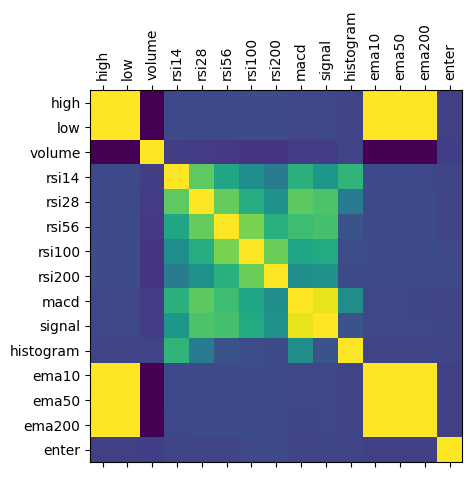

In [7]:
# show the correlation matrix
correlation_matrix = df.corr()
plt.matshow(correlation_matrix)

plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)

plt.show()

In [8]:
# train a basic neural network to predict the "enter" column

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop(columns=['enter'])
y = df['enter']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Standardize the features (optional but recommended)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the neural network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_scaled, y_train, epochs=1, batch_size=32, validation_data=(X_test_scaled, y_test))

# Evaluate the model
accuracy = model.evaluate(X_test_scaled, y_test)[1]
print(f"Accuracy: {accuracy}")

2024-02-07 15:35:08.647199: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-07 15:35:09.013284: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-07 15:35:09.013403: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-07 15:35:09.068321: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-07 15:35:09.185658: I tensorflow/core/platform/cpu_feature_guar

11711/11711 [==============================] - 4s 306us/step - loss: 0.6484 - accuracy: 0.6485
Accuracy: 0.6485393643379211


11711/11711 [==============================] - 3s 260us/step


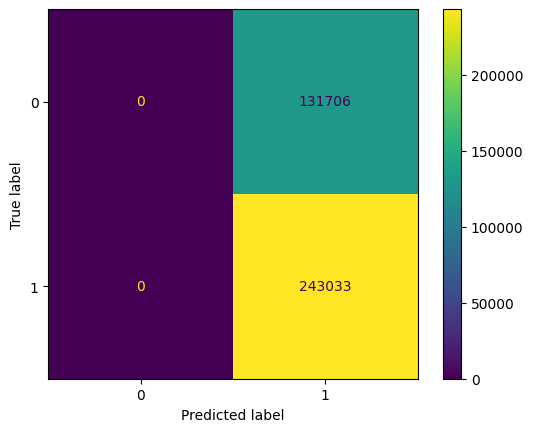

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test_scaled)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

# Set display labels for binary classification
class_labels = ['0', '1']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot()
plt.show()


Experiments: 

Failed / meaningless / accuracy within 50%:
- AAPL 5 mins
- SPY 5 mins

Possibly interesting:
- SPY 1 week: 59%? 
- SPY 2 week: 62%?
- SPY 4 week: 65%?
- AAPL 4 week: 63%

- TSLA 4 weeks: 55%